In this notebook, we explore the application of Directed Acyclic Graph (DAG)-based Graph Neural Networks (GNNs) to learn a diffusion model over a DAG structure. The objective is to test whether different an architectures are capable of predicting the output signals given some sparse inputs. Leveraging the inherent structure of the DAG will play a fundamental role in the performance of the considered architectures.

In [1]:
import numpy as np
import time
import dgl
import torch
from torch import nn
import networkx as nx
from tqdm.auto import tqdm

import src.dag_utils as dagu
import src.utils as utils
from src.arch import DAGConv, FB_DAGConv, SF_DAGConv, ADCN
from src.models import Model, LinDAGRegModel
from src.baselines_archs import GAT, MLP, MyGCNN, GraphSAGE, GIN

import os

# Ser random seed
SEED = 10
PATH = 'results/diffusion/'
SAVE = True
np.random.seed(SEED)
torch.manual_seed(SEED)
dgl.random.seed(SEED)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# torch.cuda.set_per_process_memory_fraction(.5, device=device)

cuda:0


## Default parameters and auxiliary functions

In [2]:
M = 2000

data_p = {
    'n_tries': 25,  #25,

    ## Graph parameters
    'p': 0.2,  # .2                  # Edge prob in Erdos-Renyi DAG
    'N': 100,                    # Number of nodes

    ## Signal parameters
    'M': M,                   # Number of observed signals
    'M_train': int(0.7 * M),  # Samples selected for training
    'M_val': int(0.2 * M),    # Samples selected for validation
    'M_test': int(0.1 * M),   # Samples selected for test
    'src_t': 'constant',          # 'random' or 'constant'
    'max_src_node': 25, #25,           # Maximum index of nodes allowed to be sources
    'n_sources': 5,             # Maximum Number of source nodes
    'n_p_x': .05,
    'n_p_y': .05,                 # Normalized noise power
    'max_GSO': 100,              # Maximum index of GSOs involved in the diffusion
    'min_GSO': 50,               # Minimum index of GSOs involved in the diffusion
    'n_GSOs': 25                 # Number of GSOs
}

# Model parameters
default_arch_args = {
    'in_dim': 1,        # Input dimension
    'hid_dim': 32,     # Hidden dimension
    'out_dim': 1,       # Output dimension
    'n_layers': 2,#2,  # 3 also works well          # Number of layers
    'l_act': None,
    'bias': True,
}

default_mod_p = {
    'bs': 25,           # Size of the batch
    'lr': 5e-4,         # Learning rate
    'epochs': 50,  #50,       # Number of training epochs 
    'pat': 25,  # 15        # Number of non-decreasing epoch to stop training
    'wd': 1e-4,         # Weight decay
}

In [3]:
def get_signals(d_p, GSOs):
    range_GSO = np.arange(d_p['min_GSO'], d_p['max_GSO'])
    gsos_idx = np.random.choice(range_GSO, size=d_p['n_GSOs'], replace=False)
    sel_GSOs = GSOs[gsos_idx]
    Yn_t, X_t, Y_t = dagu.create_diff_data(d_p['M'], sel_GSOs, d_p['max_src_node'], d_p['n_p_x'], d_p['n_p_y'],
                                           d_p['n_sources'], src_t=d_p['src_t'], torch_tensor=True, verb=False)
    
    X_data = {'train': X_t[:d_p['M_train']], 'val': X_t[d_p['M_train']:-d_p['M_test']], 'test': X_t[-d_p['M_test']:]}
    Y_data = {'train': Yn_t[:d_p['M_train']], 'val': Yn_t[d_p['M_train']:-d_p['M_test']],
              'test': Y_t[-d_p['M_test']:]}
        
    return X_data, Y_data, sel_GSOs, gsos_idx

def run_exps(exps, d_arc_args, d_mod_p, d_dat_p, GSOs, W, Adj, pbar, Psi=None, verb=True, exp_desc='default'):
    # Create error variables
    err_exps = np.zeros(len(exps))
    std_exps = np.zeros(len(exps))
    times_exps = np.zeros(len(exps))

    # Check if every experiment has the same signal setting
    common_signals = all('dat_p' not in exp for exp in exps)
    if common_signals:
        X_data, Y_data, sel_GSOs, sel_GSOs_idx = get_signals(d_dat_p, GSOs)

    for k, exp in enumerate(exps):
        # Combine default and experiment parameters
        arc_p = {**exp['arc_p']}
        arc_p['args'] = {**d_arc_args, **arc_p['args']} if 'args' in arc_p.keys() else {**d_arc_args}
        mod_p = {**d_mod_p, **exp['mod_p']} if 'mod_p' in exp else d_mod_p

        if not common_signals:
            d_p = {**d_dat_p, **exp['dat_p']}
            X_data, Y_data, sel_GSOs, sel_GSOs_idx = get_signals(d_p, GSOs)

        if exp['arc_p']['arch'] == LinDAGRegModel:
            Psi_sel = utils.select_GSO(arc_p, Psi.T, Psi[:,sel_GSOs_idx].T, W, Adj, sel_GSOs_idx).numpy().T
            lin_model = LinDAGRegModel(W, Psi_sel)
            t_i = time.time()
            lin_model.fit(X_data['train'], Y_data['train'])
            t_e = time.time() - t_i

            err_exps[k], std_exps[k] = lin_model.test(X_data['test'], Y_data['test'])
        else:
            GSO = utils.select_GSO(arc_p, GSOs, sel_GSOs, W, Adj, sel_GSOs_idx=sel_GSOs_idx)
            K = GSO.shape[0] if isinstance(GSO, torch.Tensor) and len(GSO.shape) == 3 else 0  
            arch = utils.instantiate_arch(arc_p, K)
            model = Model(arch, device=device)

            t_i = time.time()
            model.fit(X_data, Y_data, GSO, mod_p['lr'], mod_p['epochs'], mod_p['bs'], mod_p['wd'],
                    patience=mod_p['pat'])
            t_e = time.time() - t_i

            err_exps[k], std_exps[k] = model.test(X_data['test'], Y_data['test'], GSO)
        times_exps[k] = t_e

        # Progress
        pbar.update(1)
        if verb:
            print(f'\t-{exp_desc}. {exp["leg"]}: err: {err_exps[k]:.3f} - time: {times_exps[k]:.1f}')

    return err_exps, std_exps, times_exps

def run_exp(d_p, d_arc_args, d_mod_p, exps, verb=True):
    # Create error variables
    err = np.zeros((d_p['n_tries'], len(exps)))
    std = np.zeros((d_p['n_tries'], len(exps)))
    times = np.zeros((d_p['n_tries'], len(exps)))

    t_begin = time.time()
    # for i in range(d_p['n_tries']):
    with tqdm(total=d_p['n_tries']*len(exps), disable=False) as pbar:
        for i in range(d_p['n_tries']):
            Adj, W, GSOs, Psi = utils.get_graph_data(d_p, get_Psi=True)
            X_data, Y_data, sel_GSOs, sel_GSOs_idx = get_signals(d_p, GSOs)
            
            for j, exp in enumerate(exps):
                # Combine default and experiment parameters    
                arc_p = {**exp['arc_p']}
                arc_p['args'] = {**d_arc_args, **arc_p['args']} if 'args' in arc_p.keys() else {**d_arc_args}
                mod_p = {**d_mod_p, **exp['mod_p']} if 'mod_p' in exp.keys() else d_mod_p

                if exp['arc_p']['arch'] == LinDAGRegModel:
                    # Fit and test linear model
                    if 'transp' in arc_p.keys() and arc_p['transp']:
                        dag_T = nx.from_numpy_array(Adj, create_using=nx.DiGraph())
                        Psi = np.array([dagu.compute_Dq(dag_T, i, d_p['N']) for i in range(d_p['N'])]).T
                        arc_p['transp'] = False

                    Psi_sel = utils.select_GSO(arc_p, Psi.T, Psi[:,sel_GSOs_idx].T, W, Adj, sel_GSOs_idx).numpy().T
                    lin_model = LinDAGRegModel(W, Psi_sel)
                    t_i = time.time()
                    lin_model.fit(X_data['train'], Y_data['train'])
                    t_e = time.time() - t_i

                    err[i,j], std[i,j] = lin_model.test(X_data['test'], Y_data['test'])
                else:
                    # Fit and test nonlinear models
                    GSO = utils.select_GSO(arc_p, GSOs, sel_GSOs, W, Adj)
                    K = GSO.shape[0] if isinstance(GSO, torch.Tensor) and len(GSO.shape) == 3 else 0  
                    arch = utils.instantiate_arch(arc_p, K)                
                    model = Model(arch, device=device)

                    t_i = time.time()
                    model.fit(X_data, Y_data, GSO, mod_p['lr'], mod_p['epochs'], mod_p['bs'], mod_p['wd'], patience=mod_p['pat'])
                    t_e = time.time() - t_i
                    err[i,j], std[i,j] = model.test(X_data['test'], Y_data['test'], GSO)

                times[i,j] = t_e

                params = arch.n_params if hasattr(arch, 'n_params') else None 
                
                # Progress
                pbar.update(1)
                if verb:
                    print(f'-{i}. {exp["leg"]}: err: {err[i,j]:.3f} | std: {std[i,j]:.3f}  |' +
                          f' time: {times[i,j]:.1f} | n_params: {params}')

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')
    return err, std, times

## Preliminary results

In [4]:
mod_p_init = default_mod_p.copy()
mod_p_init['pat'] = 50

verb = True

# Experiments to be run
Exps = [
    # Our Models
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'leg': 'DCN'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 30}, 'leg': 'DCN-30'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 10}, 'leg': 'DCN-10'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 5}, 'leg': 'DCN-5'},

    {'arc_p': {'arch': DAGConv, 'GSO': 'GSOs'}, 'leg': 'DAGConv'},
    {'arc_p': {'arch': DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 30}, 'leg': 'DAGConv-30'},

    {'arc_p': {'arch': ADCN, 'GSO': 'GSOs', 'args': {'mlp_layers': 3}}, 'leg': 'ADCN-3'},
    {'arc_p': {'arch': ADCN, 'GSO': 'GSOs', 'args': {'mlp_layers': 4}}, 'leg': 'ADCN-4'},
    {'arc_p': {'arch': ADCN, 'GSO': 'GSOs', 'args': {'mlp_layers': 5}}, 'leg': 'ADCN-5'},

    {'arc_p': {'arch': ADCN, 'GSO': 'GSOs', 'args': {'act': nn.Identity(), 'mlp_layers': 4}}, 'leg': 'ADCN-4v2'},


    # Our Models - Transposed
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs', 'transp': True}, 'leg': 'DCN-T'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 30, 'transp': True}, 'leg': 'DCN-30-T'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 10, 'transp': True}, 'leg': 'DCN-10-T'},

    {'arc_p': {'arch': DAGConv, 'GSO': 'GSOs', 'transp': True}, 'leg': 'DAGConv-T'},
    {'arc_p': {'arch': DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 30, 'transp': True}, 'leg': 'DAGConv-30-T'},

    {'arc_p': {'arch': ADCN, 'GSO': 'GSOs', 'transp': True, 'args': {'mlp_layers': 4}}, 'leg': 'ADCN-4-T'},
    {'arc_p': {'arch': ADCN, 'GSO': 'GSOs', 'transp': True, 'args': {'mlp_layers': 5}}, 'leg': 'ADCN-5-T'},

    # Linear baselines
    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'GSOs'}, 'leg': 'Linear'},
    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'rnd_GSOs', 'n_gsos': 30}, 'leg': 'Linear-30'},
    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'rnd_GSOs', 'n_gsos': 10}, 'leg': 'Linear-10'},
    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'GSOs', 'transp': True}, 'leg': 'Linear-T'},
    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'rnd_GSOs', 'n_gsos': 30, 'transp': True}, 'leg': 'Linear-30-T'},
    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'rnd_GSOs', 'n_gsos': 10, 'transp': True}, 'leg': 'Linear-10-T'},

    # GNN Baselines
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 2, 'transp': False}, 'leg': 'FB-GCNN-2'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 3, 'transp': False}, 'leg': 'FB-GCNN-3'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 4, 'transp': False}, 'leg': 'FB-GCNN-4'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'A'}, 'leg': 'GNN-A'},
    {'arc_p': {'arch': GAT, 'GSO': 'A-dgl', 'args': {'num_heads': 2, 'hid_dim': 16, 'gat_params': {'attn_drop': 0}}},
     'leg': 'GAT'},
    {'arc_p': {'arch': GraphSAGE, 'GSO': 'A-dgl', 'args': {'aggregator': 'mean'}}, 'leg': 'GraphSAGE-A'},
    {'arc_p': {'arch': GIN, 'GSO': 'A-dgl', 'args': {'aggregator': 'sum'}}, 'leg': 'GIN-A'},
    {'arc_p': {'arch': GIN, 'GSO': 'A-dgl', 'args': {'aggregator': 'sum', 'mlp_layers': 4}}, 'leg': 'GIN-A-4'},
    {'arc_p': {'arch': MLP, 'GSO': None}, 'leg': 'MLP'},
    {'arc_p': {'arch': MLP, 'GSO': None, 'args': {'n_layers': 4}}, 'leg': 'MLP-4'},
]

err, std, times = run_exp(data_p, default_arch_args, mod_p_init, Exps, verb=verb)

  0%|          | 0/825 [00:00<?, ?it/s]

-0. DCN: err: 0.016 | std: 0.012  | time: 5.4 | n_params: 6433
-0. DCN-30: err: 0.049 | std: 0.017  | time: 3.8 | n_params: 1953
-0. DCN-10: err: 0.078 | std: 0.021  | time: 3.2 | n_params: 673
-0. DCN-5: err: 0.056 | std: 0.016  | time: 3.8 | n_params: 353
-0. DAGConv: err: 0.139 | std: 0.050  | time: 9.1 | n_params: 297
-0. DAGConv-30: err: 0.129 | std: 0.043  | time: 5.3 | n_params: 157
-0. ADCN-3: err: 0.114 | std: 0.041  | time: 6.6 | n_params: 4321
-0. ADCN-4: err: 0.103 | std: 0.035  | time: 8.2 | n_params: 6433
-0. ADCN-5: err: 0.101 | std: 0.033  | time: 9.1 | n_params: 8545
-0. ADCN-4v2: err: 0.113 | std: 0.040  | time: 8.2 | n_params: 6433
-0. DCN-T: err: 0.079 | std: 0.026  | time: 4.2 | n_params: 6433
-0. DCN-30-T: err: 0.113 | std: 0.030  | time: 3.9 | n_params: 1953
-0. DCN-10-T: err: 0.128 | std: 0.032  | time: 3.7 | n_params: 673
-0. DAGConv-T: err: 0.175 | std: 0.042  | time: 9.9 | n_params: 297
-0. DAGConv-30-T: err: 0.156 | std: 0.038  | time: 5.0 | n_params: 157
-0

In [6]:
# DEFAULT PARAMETERS
if SAVE:
    file_name = PATH + f'init_exp-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times)
    print('SAVED FILE:', file_name)

leg = [exp['leg'] for exp in Exps]

utils.display_data(leg, err, std, times)

SAVED FILE: results/diffusion/init_exp-constant


,Exp,Mean Err,Median Err,Mean Std,time
0,DCN,0.014191,0.010775,0.012391,5.377917
1,DCN-30,0.025895,0.011952,0.016522,4.671986
2,DCN-10,0.043212,0.023796,0.021079,4.504932
3,DCN-5,0.074488,0.025165,0.028915,4.571399
4,DAGConv,0.084014,0.060502,0.033363,10.942446
5,DAGConv-30,0.070763,0.035015,0.028305,6.388035
6,ADCN-3,0.068528,0.035311,0.030553,7.898087
7,ADCN-4,0.055694,0.024250,0.025600,9.453311
8,ADCN-5,0.052401,0.021706,0.024806,10.882157
9,ADCN-4v2,0.059112,0.027385,0.027649,9.326084


In [6]:
# file_name = PATH + 'gso_inf-constant.npz'
# err, std, times, Exps, N_GSOs = utils.load_data(file_name)

## Noise Influence Experiment

In [7]:
def influence_noise(d_dat_p, d_arc_p, d_mod_p, Noise_values, exps, noise_keys=['n_p_y']):
    err = np.zeros((d_dat_p['n_tries'], len(Noise_values), len(exps)))
    std = np.zeros((d_dat_p['n_tries'], len(Noise_values), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(Noise_values), len(exps)))

    t_begin = time.time()
    with tqdm(total=d_dat_p['n_tries']*len(exps)*len(Noise_values), disable=False) as pbar:
        for i in range(d_dat_p['n_tries']):
            print('Realization:', i)

            for j, noise in enumerate(Noise_values):
                data_params_aux = dict(d_dat_p)
                for key in noise_keys:
                    data_params_aux[key] = noise

                Adj, W, GSOs, Psi = utils.get_graph_data(data_params_aux, get_Psi=True)
                err[i,j], std[i,j], times[i,j] = run_exps(exps, d_arc_p, d_mod_p, data_params_aux, GSOs, W, Adj,
                                                          pbar, exp_desc=str(noise), Psi=Psi)

                err[i,j][err[i,j] > 1] = 1

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')

    return err, std, times

In [8]:
M = 2000
# data_soruces = dict(data_p)
# data_soruces['n_p_y'] = 0

Noise_values = np.arange(0, .51, .05)

Exps = [
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'leg': 'DCN', 'fmt': 'o-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 20}, 'leg': 'DCN-20',
     'fmt': 's--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 10}, 'leg': 'DCN-10',
     'fmt': 's--'},

    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'GSOs'}, 'leg': 'Linear', 'fmt': '1-'},
    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'rnd_GSOs', 'n_gsos': 20}, 'leg': 'Linear-Rnd-20', 'fmt': '1:'},
    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'rnd_GSOs', 'n_gsos': 10}, 'leg': 'Linear-Rnd-10', 'fmt': '1:'},

    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 2, 'transp': False}, 'leg': 'FB-GCNN-2', 'fmt': '2:'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 4, 'transp': False}, 'leg': 'FB-GCNN-3', 'fmt': '2--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 6, 'transp': False}, 'leg': 'FB-GCNN-4', 'fmt': '2-'},

    {'arc_p': {'arch': MyGCNN, 'GSO': 'A'}, 'leg': 'GNN-A', 'fmt': 'v:'},
    {'arc_p': {'arch': GAT, 'GSO': 'A-dgl', 'args': {'num_heads': 2, 'hid_dim': 16, 'gat_params': {'attn_drop': 0}}},
     'leg': 'GAT-A', 'fmt': '^:'},
    {'arc_p': {'arch': GraphSAGE, 'GSO': 'A-dgl', 'args': {'hid_dim': 16, 'aggregator': 'mean'}}, 'leg': 'GraphSAGE-A',
     'fmt': '>:'},
    {'arc_p': {'arch': GIN, 'GSO': 'A-dgl',  'args': {'hid_dim': 16, 'aggregator': 'sum'}}, 'leg': 'GIN-A',
     'fmt': '<:'},
]

err, std, times = influence_noise(data_p, default_arch_args, default_mod_p, Noise_values, Exps,
                                  noise_keys=['n_p_x', 'n_p_y'])


  0%|          | 0/143 [00:00<?, ?it/s]

Realization: 0
	-0.0. DCN: err: 0.018 - time: 0.5
	-0.0. DCN-20: err: 0.026 - time: 0.3
	-0.0. DCN-10: err: 0.049 - time: 0.4
	-0.0. Linear: err: 0.008 - time: 2.2
	-0.0. Linear-Rnd-20: err: 0.010 - time: 0.7
	-0.0. Linear-Rnd-10: err: 0.013 - time: 0.7
	-0.0. FB-GCNN-2: err: 0.425 - time: 0.4
	-0.0. FB-GCNN-3: err: 0.377 - time: 0.4
	-0.0. FB-GCNN-4: err: 0.184 - time: 0.3
	-0.0. GNN-A: err: 0.440 - time: 0.4
	-0.0. GAT-A: err: 0.754 - time: 1.1
	-0.0. GraphSAGE-A: err: 100.768 - time: 0.8
	-0.0. GIN-A: err: 0.833 - time: 0.8
	-0.05. DCN: err: 0.087 - time: 0.5
	-0.05. DCN-20: err: 0.149 - time: 0.5
	-0.05. DCN-10: err: 0.180 - time: 0.5
	-0.05. Linear: err: 0.046 - time: 2.5
	-0.05. Linear-Rnd-20: err: 0.071 - time: 0.7
	-0.05. Linear-Rnd-10: err: 0.136 - time: 0.6
	-0.05. FB-GCNN-2: err: 0.583 - time: 0.2
	-0.05. FB-GCNN-3: err: 0.246 - time: 0.3
	-0.05. FB-GCNN-4: err: 0.242 - time: 0.4
	-0.05. GNN-A: err: 0.486 - time: 0.4
	-0.05. GAT-A: err: 0.737 - time: 0.8
	-0.05. GraphSAGE-A:

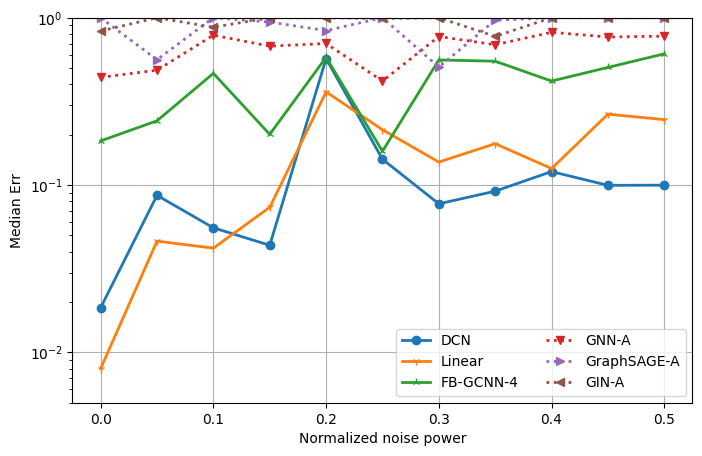

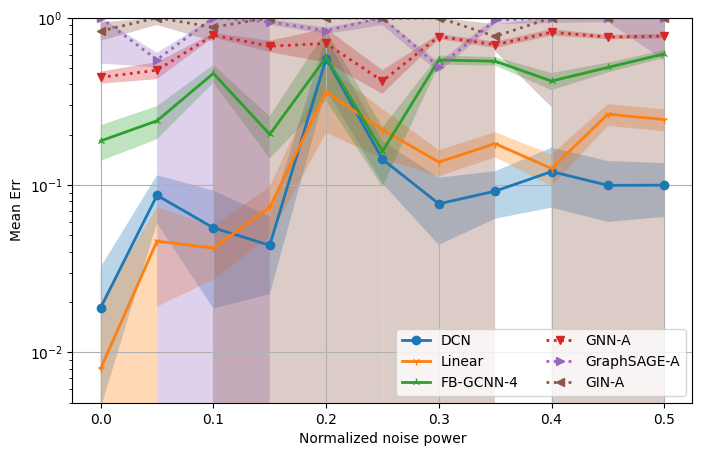

In [9]:
mean_err = err.mean(axis=0)
std_err = std.mean(axis=0)
med_err = np.median(err, axis=0)
prctile25_err = np.percentile(err, 25, axis=0)
prctile75_err = np.percentile(err, 75, axis=0)

if SAVE:
    file_name = PATH + f'noise/noise_inf-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=Noise_values)
    print('SAVED FILE:', file_name)

    # Save csv files for pgfplot
    file_name_data = f'{file_name}-mean_err.csv'
    utils.data_to_csv(file_name_data, Exps, Noise_values, mean_err)
    file_name_data = f'{file_name}-std_up_err.csv'
    utils.data_to_csv(file_name_data, Exps, Noise_values, mean_err + std_err)
    file_name_data = f'{file_name}-std_down_err.csv'
    utils.data_to_csv(file_name_data, Exps, Noise_values, mean_err - std_err)
    file_name_data = f'{file_name}-med_err.csv'
    utils.data_to_csv(file_name_data, Exps, Noise_values, med_err)
    file_name_data = f'{file_name}-prct75_err.csv'
    utils.data_to_csv(file_name_data, Exps, Noise_values, prctile75_err)
    file_name_data = f'{file_name}-prct25_err.csv'
    utils.data_to_csv(file_name_data, Exps, Noise_values, prctile25_err)

legend = [exp['leg'] for exp in Exps]

skip = [1, 2, 4, 5, 6, 7, 10] #[1,3,5,6, 7, 11, 12]
utils.plot_results(med_err, Noise_values, Exps, 'Normalized noise power', skip_idx=skip, n_cols=2, ylabel='Median Err',
                   ylim_top=1, logy=True, prctile_up=prctile75_err, prctile_low=prctile25_err, ylim_bottom=5e-3)

utils.plot_results(mean_err, Noise_values, Exps, 'Normalized noise power', skip_idx=skip, n_cols=2, ylabel='Mean Err',
                   ylim_top=1, logy=True, std=std_err, ylim_bottom=5e-3)




In [10]:
# file_name = PATH + 'noise/noise_inf-constant-noisy_test.npz'
# err, std, times, Exps, Noise_values = utils.load_data(file_name)

## Additional Eperiments

### Varying the size of the graph

In [11]:
def influence_graph_size(d_dat_p, d_arc_p, d_mod_p, N_nodes, mean_edges_per_node, exps,
                         sel_GSOs='last', incr_GSOs=True, inc_srcs=True):
    err = np.zeros((d_dat_p['n_tries'], len(N_nodes), len(exps)))
    std = np.zeros((d_dat_p['n_tries'], len(N_nodes), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(N_nodes), len(exps)))
    
    t_begin = time.time()
    with tqdm(total=d_dat_p['n_tries']*len(exps)*len(N_nodes), disable=False) as pbar:
        for i in range(d_dat_p['n_tries']):
            print('Realization:', i)

            for j, n_nodes in enumerate(N_nodes):
                data_params_aux = dict(d_dat_p)
                data_params_aux['N'] = n_nodes
                edges = n_nodes*mean_edges_per_node
                data_params_aux['p'] = float(edges*2)/float(n_nodes**2 - n_nodes)

                if inc_srcs:
                    data_params_aux['max_src_node'] = int(n_nodes/4)
                    data_params_aux['n_sources'] = max(int(n_nodes/20), 1)

                if sel_GSOs == 'all':
                    data_params_aux['max_GSO'] = n_nodes
                    data_params_aux['min_GSO'] = 0
                else:
                    # Always use second half of nodes to generate data
                    data_params_aux['max_GSO'] = n_nodes
                    data_params_aux['min_GSO'] = int(n_nodes/2)
                
                available_nodes = data_params_aux['max_GSO'] - data_params_aux['min_GSO']
                if incr_GSOs: # and available_nodes > d_dat_p['n_GSOs']:
                    data_params_aux['n_GSOs'] = int(available_nodes/2)  # max(int(available_nodes/2), d_dat_p['n_GSOs'])
                else:
                    data_params_aux['n_GSOs'] = min(d_dat_p['n_GSOs'], available_nodes)
                

                Adj, W, GSOs, Psi = utils.get_graph_data(data_params_aux, get_Psi=True)

                exp_desc = f'N: {Adj.shape[0]}, p: { data_params_aux["p"]:.3f}'

                err[i,j], std[i,j], times[i,j] = run_exps(exps, d_arc_p, d_mod_p, data_params_aux, GSOs, W,
                                                          Adj, pbar, exp_desc=exp_desc, Psi=Psi)

                err[i,j][err[i,j] > 1] = 1

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')

    return err, std, times

In [12]:
mean_edges_per_node = 5
N_nodes = np.array([25, 50, 100, 200, 400]) # np.logspace(np.log10(25), np.log10(400), 7, dtype=int) 

Exps = [
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'leg': 'DCN', 'fmt': 'o-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 20}, 'leg': 'DCN-20', 'fmt': 'o--'},

    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'GSOs'}, 'leg': 'Linear', 'fmt': 's-'},

    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 4, 'transp': False}, 'leg': 'FB-GCNN-3', 'fmt': '2:'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'A'}, 'leg': 'GNN-A', 'fmt': 'v:'},
    {'arc_p': {'arch': GAT, 'GSO': 'A-dgl', 'args': {'num_heads': 2, 'hid_dim': 16, 'gat_params': {'attn_drop': 0}}},
     'leg': 'GAT-A', 'fmt': '^:'},
    {'arc_p': {'arch': GraphSAGE, 'GSO': 'A-dgl', 'args': {'hid_dim': 16, 'aggregator': 'mean'}}, 'leg': 'GraphSAGE-A',
     'fmt': '>:'},
    {'arc_p': {'arch': GIN, 'GSO': 'A-dgl', 'args': {'hid_dim': 16, 'aggregator': 'sum'}}, 'leg': 'GIN-A',
     'fmt': '<:'},
    ]

err, std, times = influence_graph_size(data_p, default_arch_args, default_mod_p, N_nodes,
                                       mean_edges_per_node, Exps)


  0%|          | 0/40 [00:00<?, ?it/s]

Realization: 0
	-N: 25, p: 0.417. DCN: err: 0.019 - time: 0.5
	-N: 25, p: 0.417. DCN-20: err: 0.022 - time: 0.4
	-N: 25, p: 0.417. Linear: err: 0.031 - time: 0.1
	-N: 25, p: 0.417. FB-GCNN-3: err: 0.574 - time: 0.3
	-N: 25, p: 0.417. GNN-A: err: 0.944 - time: 0.2
	-N: 25, p: 0.417. GAT-A: err: 0.888 - time: 1.1
	-N: 25, p: 0.417. GraphSAGE-A: err: 1.467 - time: 0.7
	-N: 25, p: 0.417. GIN-A: err: 0.564 - time: 0.4
	-N: 50, p: 0.204. DCN: err: 0.148 - time: 0.2
	-N: 50, p: 0.204. DCN-20: err: 0.324 - time: 0.3
	-N: 50, p: 0.204. Linear: err: 0.058 - time: 0.2
	-N: 50, p: 0.204. FB-GCNN-3: err: 0.501 - time: 0.2
	-N: 50, p: 0.204. GNN-A: err: 0.662 - time: 0.2
	-N: 50, p: 0.204. GAT-A: err: 0.816 - time: 0.6
	-N: 50, p: 0.204. GraphSAGE-A: err: 18.291 - time: 0.7
	-N: 50, p: 0.204. GIN-A: err: 0.712 - time: 0.8
	-N: 100, p: 0.101. DCN: err: 0.034 - time: 0.4
	-N: 100, p: 0.101. DCN-20: err: 0.041 - time: 0.5
	-N: 100, p: 0.101. Linear: err: 0.023 - time: 1.9
	-N: 100, p: 0.101. FB-GCNN-3:

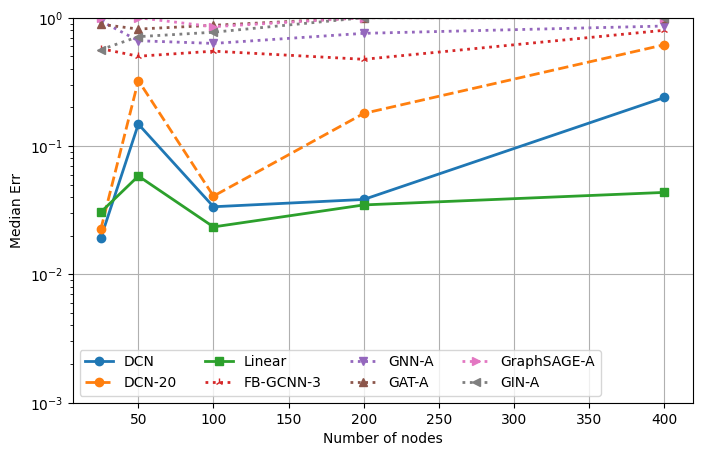

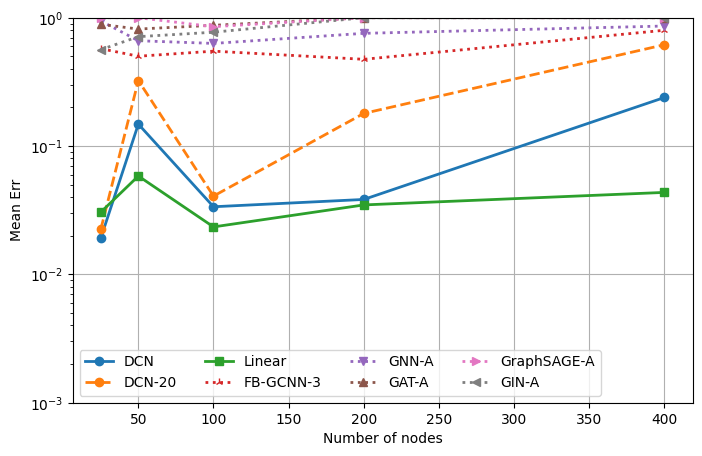

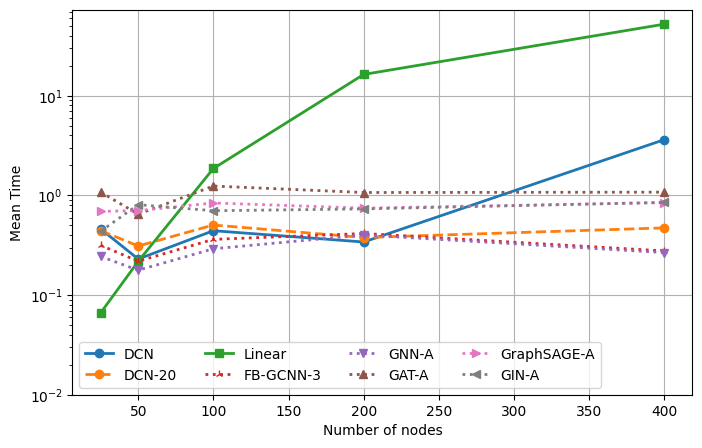

In [13]:
mean_err = err.mean(axis=0)
std_err = err.std(axis=0)
med_err = np.median(err, axis=0)
std_err = err.std(axis=0)
prctile25_err = np.percentile(err, 25, axis=0)
prctile75_err = np.percentile(err, 75, axis=0)
mean_time = times.mean(axis=0)

if SAVE:
    file_name = PATH + f'graph_size/n_nodes_inf-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=N_nodes)
    print('SAVED FILE:', file_name)

    # Save csv files for pgfplot
    file_name_data = f'{file_name}-mean_err.csv'
    utils.data_to_csv(file_name_data, Exps, N_nodes, mean_err)
    file_name_data = f'{file_name}-std_up_err.csv'
    utils.data_to_csv(file_name_data, Exps, N_nodes, mean_err + std_err)
    file_name_data = f'{file_name}-std_down_err.csv'
    utils.data_to_csv(file_name_data, Exps, N_nodes, mean_err - std_err)
    file_name_data = f'{file_name}-med_err.csv'
    utils.data_to_csv(file_name_data, Exps, N_nodes, med_err)
    file_name_data = f'{file_name}-prct75_err.csv'
    utils.data_to_csv(file_name_data, Exps, N_nodes, prctile75_err)
    file_name_data = f'{file_name}-prct25_err.csv'
    utils.data_to_csv(file_name_data, Exps, N_nodes, prctile25_err)


### WITH PRCTILES
skip = []  # [1, 6, 9]
legend = [exp['leg'] for exp in Exps]
utils.plot_results(med_err, N_nodes, Exps, 'Number of nodes', skip_idx=skip, n_cols=4,
                   ylabel='Median Err', logy=True, ylim_top=1, ylim_bottom=1e-3)

utils.plot_results(mean_err, N_nodes, Exps, 'Number of nodes', skip_idx=skip, n_cols=4,
                   ylabel='Mean Err', logy=True, ylim_top=1, ylim_bottom=1e-3)

utils.plot_results(mean_time, N_nodes, Exps, 'Number of nodes', skip_idx=skip, n_cols=4,
                   ylabel='Mean Time', logy=True, ylim_top=None, ylim_bottom=1e-2)

In [14]:
# file_name = PATH + 'graph_size/n_nodes_inf-constant.npz'
# err, std, times, Exps, N_nodes = utils.load_data(file_name)

### Influence of selected GSOs

In [15]:
def influence_gso_exp(d_dat_p, d_arc_p, d_mod_p, N_GSOs, exps):
    err = np.zeros((d_dat_p['n_tries'], len(N_GSOs), len(exps)))
    std = np.zeros((d_dat_p['n_tries'], len(N_GSOs), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(N_GSOs), len(exps)))
    t_begin = time.time()

    with tqdm(total=d_dat_p['n_tries']*len(exps)*len(N_GSOs), disable=False) as pbar:
        for i in range(d_dat_p['n_tries']):
            print('Iteration:', i)
            Adj, W, GSOs, Psi = utils.get_graph_data(d_dat_p, get_Psi=True)

            for j, n_gsos in enumerate(N_GSOs):
                data_params_aux = dict(d_dat_p)
                data_params_aux['n_GSOs'] = n_gsos
                err[i,j], std[i,j], times[i,j] = run_exps(exps, d_arc_p, d_mod_p, data_params_aux, GSOs, W,
                                                        Adj, pbar, Psi=Psi, exp_desc=str(n_gsos))

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')
    return err, std, times


In [16]:
Exps = [
    {'dat_p': {'min_GSO': 0, 'max_GSO': 100}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'mod_p': {},
     'leg': 'DCN, All', 'fmt': 'o-'},
    # {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'GSOs'}, 'leg': 'Linear', 'fmt': '1-'},
    {'dat_p': {'min_GSO': 0, 'max_GSO': 100}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 20},
     'mod_p': {}, 'leg': 'DCN-Rnd-20, All', 'fmt': 's-'},
    {'dat_p': {'min_GSO': 0, 'max_GSO': 100}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 3, 'transp': False},
     'leg': 'FB-GCNN-3', 'fmt': '2-'},


    
    
    {'dat_p': {'min_GSO': 0, 'max_GSO': 60}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'mod_p': {},
     'leg': 'DCN, Firsts', 'fmt': 'o--'},
    {'dat_p': {'min_GSO': 0, 'max_GSO': 60}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 20},
     'mod_p': {}, 'leg': 'DCN-Rnd-20, Firsts', 'fmt': 's--'},
    {'dat_p': {'min_GSO': 0, 'max_GSO': 60}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 3, 'transp': False},
     'leg': 'FB-GCNN-3', 'fmt': '2--'},

    {'dat_p': {'min_GSO': 40, 'max_GSO': 100}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'mod_p': {},
     'leg': 'DCN, Lasts', 'fmt': 'o:'},
    {'dat_p': {'min_GSO': 40, 'max_GSO': 100}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 20},
     'leg': 'DCN-Rnd-20, Lasts', 'fmt': 's:'},
    {'dat_p': {'min_GSO': 40, 'max_GSO': 100}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 3, 'transp': False},
     'leg': 'FB-GCNN-3', 'fmt': '2:'},
    ]

N_GSOs = np.arange(5, 41, 5)

err, std, times = influence_gso_exp(data_p, default_arch_args, default_mod_p, N_GSOs, Exps)

  0%|          | 0/72 [00:00<?, ?it/s]

Iteration: 0
	-5. DCN, All: err: 0.146 - time: 0.2
	-5. DCN-Rnd-20, All: err: 0.114 - time: 0.1
	-5. FB-GCNN-3: err: 0.368 - time: 0.2
	-5. DCN, Firsts: err: 0.088 - time: 0.3
	-5. DCN-Rnd-20, Firsts: err: 0.046 - time: 0.4
	-5. FB-GCNN-3: err: 0.141 - time: 0.4
	-5. DCN, Lasts: err: 0.254 - time: 0.5
	-5. DCN-Rnd-20, Lasts: err: 0.096 - time: 0.4
	-5. FB-GCNN-3: err: 0.578 - time: 0.4
	-10. DCN, All: err: 0.057 - time: 0.4
	-10. DCN-Rnd-20, All: err: 0.064 - time: 0.3
	-10. FB-GCNN-3: err: 0.371 - time: 0.2
	-10. DCN, Firsts: err: 0.043 - time: 0.3
	-10. DCN-Rnd-20, Firsts: err: 0.055 - time: 0.2
	-10. FB-GCNN-3: err: 0.472 - time: 0.3
	-10. DCN, Lasts: err: 0.032 - time: 0.2
	-10. DCN-Rnd-20, Lasts: err: 0.075 - time: 0.2
	-10. FB-GCNN-3: err: 0.247 - time: 0.2
	-15. DCN, All: err: 0.034 - time: 0.1
	-15. DCN-Rnd-20, All: err: 0.044 - time: 0.4
	-15. FB-GCNN-3: err: 0.282 - time: 0.2
	-15. DCN, Firsts: err: 0.194 - time: 0.4
	-15. DCN-Rnd-20, Firsts: err: 0.038 - time: 0.4
	-15. FB-G

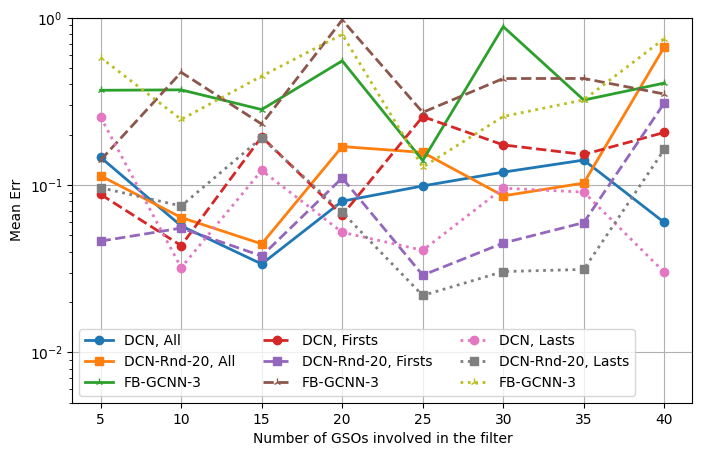

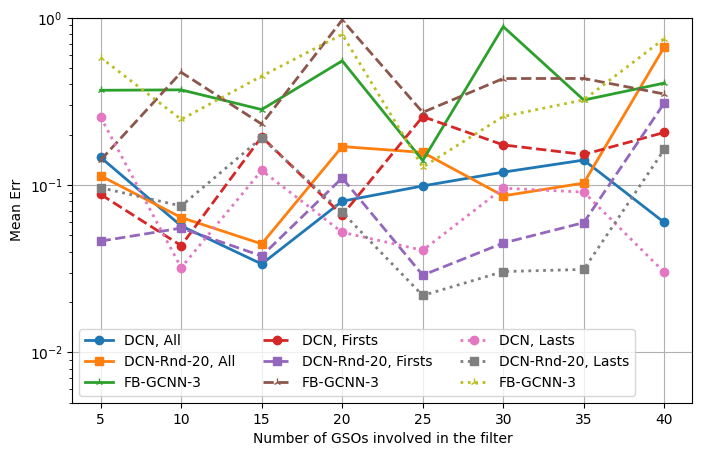

In [17]:
if SAVE:
    file_name = PATH + f'gso_inf-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=N_GSOs)
    print('SAVED FILE:', file_name)

mean_err = err.mean(axis=0)
med_err = np.median(err, axis=0)

skip_idx = [] # [2, 3, 6, 7, 10, 11]
utils.plot_results(mean_err, N_GSOs, Exps, 'Number of GSOs involved in the filter',
                   skip_idx=skip_idx, n_cols=3, ylim_bottom=5e-3)

utils.plot_results(med_err, N_GSOs, Exps, 'Number of GSOs involved in the filter',
                   skip_idx=skip_idx, n_cols=3, ylim_bottom=5e-3)

# skip_idx = [0, 1, 4, 5, 8, 9]
# utils.plot_results(med_err, N_GSOs, Exps, 'Number of GSOs involved in the filter',
#                    skip_idx=skip_idx, n_cols=3)

In [18]:
# file_name = PATH + 'gso_inf-constant.npz'
# err, std, times, Exps, N_GSOs = utils.load_data(file_name)

### Influence of the number of source nodes

In [19]:
def influence_sources_exp(d_dat_p, d_arc_p, d_mod_p, N_sources, exps):
    err = np.zeros((d_dat_p['n_tries'], len(N_sources), len(exps)))
    std = np.zeros((d_dat_p['n_tries'], len(N_sources), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(N_sources), len(exps)))
    
    t_begin = time.time()
    with tqdm(total=d_dat_p['n_tries']*len(exps)*len(N_sources), disable=False) as pbar:
        for i in range(d_dat_p['n_tries']):
            print('Iteration:', i)

            Adj, W, GSOs, Psi = utils.get_graph_data(d_dat_p, get_Psi=True)

            for j, n_sources in enumerate(N_sources):
                data_params_aux = dict(d_dat_p)
                data_params_aux['n_sources'] = n_sources
                err[i,j], std[i,j], times[i,j] = run_exps(exps, d_arc_p, d_mod_p, data_params_aux, GSOs, W,
                                                        Adj, pbar, Psi=Psi, exp_desc=str(n_sources))

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')
    return err, std, times

In [20]:
M = 2000
data_soruces = dict(data_p)
data_soruces['max_src_node'] = 50

N_sources = [1, 10, 20, 30, 40, 50]  #[1, 5, 10, 15, 20, 25]

Exps = [
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'mod_p': {}, 'leg': 'DCN', 'fmt': 'o-'},
    # {'arc_p': {'arch': FB_DAGConv, 'GSO': 'sel_GSOs'}, 'mod_p': {}, 'leg': 'DCN-Prior', 'fmt': 'P--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 20}, 'mod_p': {}, 'leg': 'DCN-20', 'fmt': 'o--'},

    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'GSOs'}, 'leg': 'Linear', 'fmt': 's-'},
    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'rnd_GSOs', 'n_gsos': 20}, 'leg': 'Linear-20', 'fmt': 's--'},

    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 4, 'transp': False}, 'leg': 'FB-GCNN-3', 'fmt': '1:'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'A'}, 'leg': 'GNN-A', 'fmt': 'v:'},
    {'arc_p': {'arch': GAT, 'GSO': 'A-dgl', 'args': {'num_heads': 2, 'hid_dim': 16, 'gat_params': {'attn_drop': 0}}},
     'leg': 'GAT-A', 'fmt': '^:'},
    {'arc_p': {'arch': GraphSAGE, 'GSO': 'A-dgl', 'args': {'hid_dim': 16, 'aggregator': 'mean'}}, 'leg': 'GraphSAGE-A',
     'fmt': '>:'},
    {'arc_p': {'arch': GIN, 'GSO': 'A-dgl', 'args': {'hid_dim': 16, 'aggregator': 'sum'}}, 'leg': 'GIN-A',
     'fmt': '<:'},
    ]

err, std, times = influence_sources_exp(data_soruces, default_arch_args, default_mod_p, N_sources, Exps)


  0%|          | 0/54 [00:00<?, ?it/s]

Iteration: 0
	-1. DCN: err: 0.029 - time: 0.2
	-1. DCN-20: err: 0.019 - time: 0.2
	-1. Linear: err: 0.035 - time: 1.6
	-1. Linear-20: err: 0.043 - time: 0.6
	-1. FB-GCNN-3: err: 0.590 - time: 0.4
	-1. GNN-A: err: 0.958 - time: 0.2
	-1. GAT-A: err: 0.896 - time: 1.0
	-1. GraphSAGE-A: err: 108.869 - time: 0.6
	-1. GIN-A: err: 0.565 - time: 0.7
	-10. DCN: err: 0.079 - time: 0.2
	-10. DCN-20: err: 0.132 - time: 0.3
	-10. Linear: err: 0.035 - time: 1.7
	-10. Linear-20: err: 0.066 - time: 0.6
	-10. FB-GCNN-3: err: 0.450 - time: 0.4
	-10. GNN-A: err: 0.588 - time: 0.4
	-10. GAT-A: err: 0.763 - time: 1.1
	-10. GraphSAGE-A: err: 5.586 - time: 0.6
	-10. GIN-A: err: 0.709 - time: 0.7
	-20. DCN: err: 0.074 - time: 0.3
	-20. DCN-20: err: 0.090 - time: 0.3
	-20. Linear: err: 0.027 - time: 1.2
	-20. Linear-20: err: 0.063 - time: 0.5
	-20. FB-GCNN-3: err: 0.090 - time: 0.2
	-20. GNN-A: err: 0.278 - time: 0.2
	-20. GAT-A: err: 0.705 - time: 0.9
	-20. GraphSAGE-A: err: 401.550 - time: 0.8
	-20. GIN-A: e

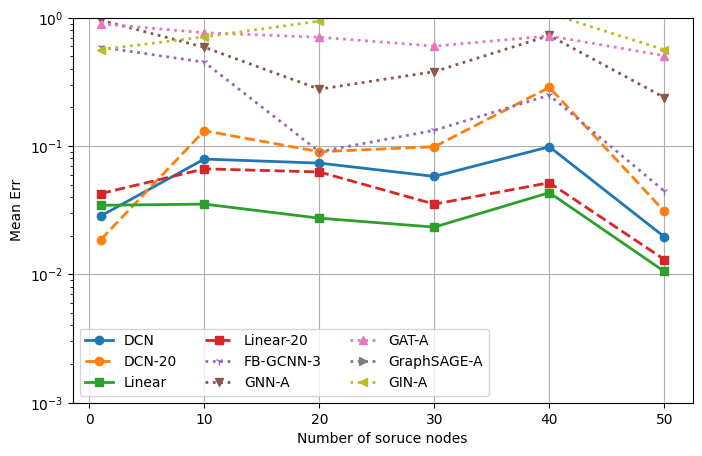

In [21]:
if SAVE:
    file_name = PATH + f'sel_nodes/src_nodes_inf-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=N_sources)
    print('SAVED FILE:', file_name)

mean_err = err.mean(axis=0)
med_err = np.median(err, axis=0)
legend = [exp['leg'] for exp in Exps]
utils.plot_results(mean_err, N_sources, Exps, 'Number of soruce nodes', ylim_bottom=1e-3)


In [22]:
# file_name = PATH + 'src_nodes_inf-constant.npz'
# err, std, times, Exps, N_sources = utils.load_data(file_name)

### Number of randomly selected GSOs

In [32]:
def influence_selected_gsp_exp(d_dat_p, d_arc_p, d_mod_p, N_GSOs, exps):
    err = np.zeros((d_dat_p['n_tries'], len(N_GSOs), len(exps)))
    std = np.zeros((d_dat_p['n_tries'], len(N_GSOs), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(N_GSOs), len(exps)))
    
    t_begin = time.time()
    with tqdm(total=d_dat_p['n_tries']*len(exps)*len(N_GSOs), disable=False) as pbar:
        for i in range(d_dat_p['n_tries']):
            print('Realization:', i)

            Adj, W, GSOs, Psi = utils.get_graph_data(d_dat_p, get_Psi=True)

            for j, n_gsos in enumerate(N_GSOs):
                exps_aux = exps.copy()
                [exp['arc_p'].update({'n_gsos': n_gsos})  for exp in exps_aux]

                err[i,j], std[i,j], times[i,j] = run_exps(exps_aux, d_arc_p, d_mod_p, d_dat_p, GSOs, W,
                                                          Adj, pbar, Psi=Psi, exp_desc=str(n_gsos))

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')
    return err, std, times

#### Data generated with all GSOs

In [33]:
data_rnd_gsos = dict(data_p)
data_rnd_gsos['min_GSO'] = 0
data_rnd_gsos['max_GSO'] = 100
data_rnd_gsos['p'] = .1

M = 2000
N_GSOs = [5, 10, 15, 20, 25, 30, 45, 50, 55, 60]

Exps = [
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'leg': 'DCN', 'fmt': 'o-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs'}, 'leg': 'DCN-Rnd', 'fmt': 'v-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'first_GSOs'}, 'leg': 'DCN-First', 'fmt': '^-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'last_GSOs'}, 'leg': 'DCN-Last', 'fmt': '>-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'no_sel_GSOs'}, 'leg': 'DCN-NoSel', 'fmt': '<-'},

    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'GSOs'}, 'leg': 'Linear', 'fmt': '1--'},
    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'rnd_GSOs'}, 'leg': 'Linear-Rnd', 'fmt': '2--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 4, 'transp': False}, 'leg': 'FB-GCNN-4', 'fmt': '3:'},
    ]

err, std, times = influence_selected_gsp_exp(data_rnd_gsos, default_arch_args, default_mod_p, N_GSOs, Exps)


  0%|          | 0/80 [00:00<?, ?it/s]

Realization: 0
	-5. DCN: err: 0.111 - time: 0.1
	-5. DCN-Rnd: err: 0.324 - time: 0.1
	-5. DCN-First: err: 0.672 - time: 0.1
	-5. DCN-Last: err: 0.456 - time: 0.1
	-5. DCN-NoSel: err: 0.337 - time: 0.1
	-5. Linear: err: 0.078 - time: 0.3
	-5. Linear-Rnd: err: 0.482 - time: 0.1
	-5. FB-GCNN-4: err: 0.559 - time: 0.1
	-10. DCN: err: 0.038 - time: 0.1
	-10. DCN-Rnd: err: 0.078 - time: 0.1
	-10. DCN-First: err: 0.637 - time: 0.1
	-10. DCN-Last: err: 0.128 - time: 0.1
	-10. DCN-NoSel: err: 0.133 - time: 0.1
	-10. Linear: err: 0.030 - time: 0.3
	-10. Linear-Rnd: err: 0.071 - time: 0.1
	-10. FB-GCNN-4: err: 0.470 - time: 0.1
	-15. DCN: err: 0.060 - time: 0.1
	-15. DCN-Rnd: err: 0.144 - time: 0.1
	-15. DCN-First: err: 0.641 - time: 0.1
	-15. DCN-Last: err: 0.130 - time: 0.1
	-15. DCN-NoSel: err: 0.138 - time: 0.1
	-15. Linear: err: 0.045 - time: 0.3
	-15. Linear-Rnd: err: 0.105 - time: 0.1
	-15. FB-GCNN-4: err: 0.620 - time: 0.1
	-20. DCN: err: 0.107 - time: 0.1
	-20. DCN-Rnd: err: 0.271 - time

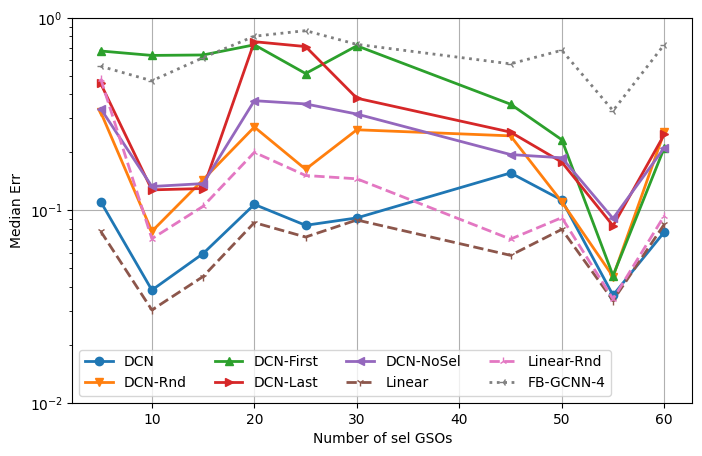

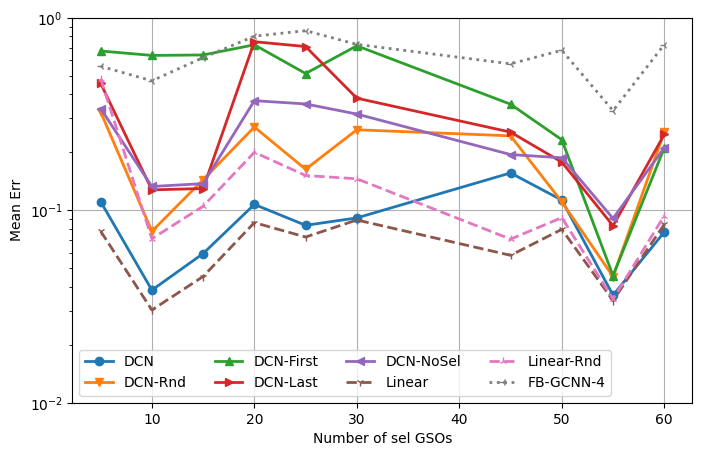

In [34]:
if SAVE:
    file_name = PATH + f'sel_gso_inf-from_all_gso-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=N_GSOs)
    print('SAVED FILE:', file_name)

mean_err = err.mean(axis=0)
mean_time = times.mean(axis=0)
med_err = np.median(err, axis=0)
med_time = np.median(times, axis=0)
legend = [exp['leg'] for exp in Exps]

# Selected
# skip = [0, 1, 2]
utils.plot_results(mean_err, N_GSOs, Exps, 'Number of sel GSOs', n_cols=4, ylabel='Median Err')

# All
utils.plot_results(med_err, N_GSOs, Exps, 'Number of sel GSOs', n_cols=4)

In [35]:
# file_name = PATH + 'sel_gso_inf-from_all_gso-constant.npz'
# err, std, times, Exps, N_GSOs = utils.load_data(file_name)

#### Data generated with last GSOs

In [36]:
M = 2000
N_GSOs = [5, 10, 15, 20, 25, 30, 45, 50]

data_rnd_gsos = dict(data_p)
data_rnd_gsos['min_GSO'] = 49
data_rnd_gsos['max_GSO'] = 100
data_rnd_gsos['p'] = .1

Exps = [
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'mod_p': {}, 'leg': 'DCN', 'fmt': 'o-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs'}, 'mod_p': {}, 'leg': 'DCN-Rnd', 'fmt': 'v-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'first_GSOs'}, 'mod_p': {}, 'leg': 'DCN-First', 'fmt': '^-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'last_GSOs'}, 'mod_p': {}, 'leg': 'DCN-Last', 'fmt': '>-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'no_sel_GSOs'}, 'mod_p': {}, 'leg': 'DCN-NoSel', 'fmt': '<-'},

    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'GSOs'}, 'leg': 'Linear', 'fmt': '1--'},
    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'rnd_GSOs'}, 'leg': 'Linear-Rnd', 'fmt': '2--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 4, 'transp': False}, 'leg': 'FB-GCNN-4', 'fmt': '3:'},
    ]

err, std, times = influence_selected_gsp_exp(data_rnd_gsos, default_arch_args, default_mod_p, N_GSOs, Exps)


  0%|          | 0/64 [00:00<?, ?it/s]

Realization: 0
	-5. DCN: err: 0.102 - time: 0.1
	-5. DCN-Rnd: err: 0.570 - time: 0.1
	-5. DCN-First: err: 0.829 - time: 0.1
	-5. DCN-Last: err: 0.206 - time: 0.1
	-5. DCN-NoSel: err: 0.611 - time: 0.1
	-5. Linear: err: 0.063 - time: 0.3
	-5. Linear-Rnd: err: 0.179 - time: 0.1
	-5. FB-GCNN-4: err: 0.488 - time: 0.1
	-10. DCN: err: 0.069 - time: 0.1
	-10. DCN-Rnd: err: 0.403 - time: 0.1
	-10. DCN-First: err: 0.806 - time: 0.1
	-10. DCN-Last: err: 0.119 - time: 0.1
	-10. DCN-NoSel: err: 0.387 - time: 0.1
	-10. Linear: err: 0.060 - time: 0.3
	-10. Linear-Rnd: err: 0.128 - time: 0.1
	-10. FB-GCNN-4: err: 0.533 - time: 0.1
	-15. DCN: err: 0.085 - time: 0.1
	-15. DCN-Rnd: err: 0.240 - time: 0.1
	-15. DCN-First: err: 0.665 - time: 0.1
	-15. DCN-Last: err: 0.207 - time: 0.1
	-15. DCN-NoSel: err: 0.247 - time: 0.1
	-15. Linear: err: 0.047 - time: 0.3
	-15. Linear-Rnd: err: 0.145 - time: 0.1
	-15. FB-GCNN-4: err: 0.534 - time: 0.1
	-20. DCN: err: 0.060 - time: 0.1
	-20. DCN-Rnd: err: 0.136 - time

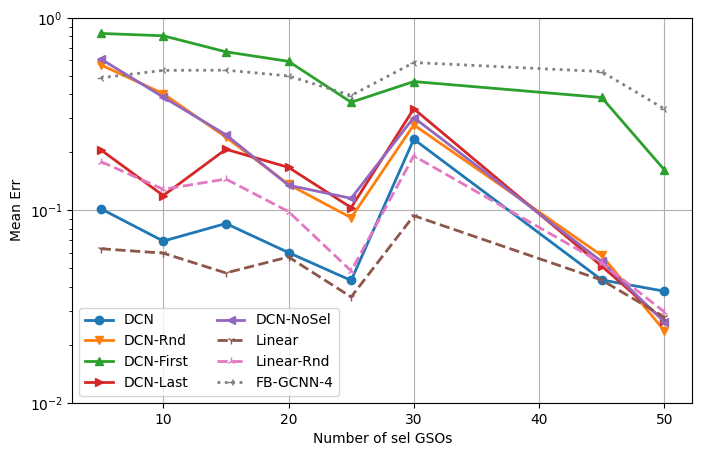

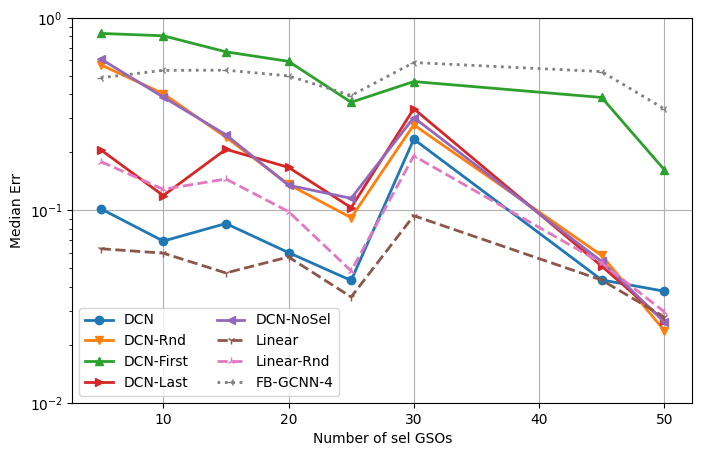

In [37]:
if SAVE:
    file_name = PATH + f'sel_gso_inf-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=N_GSOs)
    print('SAVED FILE:', file_name)

mean_err = err.mean(axis=0)
mean_time = times.mean(axis=0)
med_err = np.median(err, axis=0)
med_time = np.median(times, axis=0)
legend = [exp['leg'] for exp in Exps]
utils.plot_results(mean_err, N_GSOs, Exps, 'Number of sel GSOs', n_cols=2, ylabel='Mean Err')
utils.plot_results(med_err, N_GSOs, Exps, 'Number of sel GSOs', n_cols=2, ylabel='Median Err')

In [38]:
# file_name = PATH + 'sel_gso_inf-constant.npz'
# err, std, times, Exps, N_GSOs = utils.load_data(file_name)

### Influence of number of Layers

In [39]:
def influence_n_layers_exp(d_dat_p, d_arc_p, d_mod_p, N_layers, exps):
    err = np.zeros((d_dat_p['n_tries'], len(N_layers), len(exps)))
    std = np.zeros((d_dat_p['n_tries'], len(N_layers), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(N_layers), len(exps)))
    
    t_begin = time.time()
    with tqdm(total=d_dat_p['n_tries']*len(exps)*len(N_layers), disable=False) as pbar:
        for i in range(d_dat_p['n_tries']):
            print('Realization:', i)

            Adj, W, GSOs, Psi = utils.get_graph_data(d_dat_p, get_Psi=True)

            for j, n_layers in enumerate(N_layers):
                arch_params_aux = dict(d_arc_p)
                arch_params_aux['n_layers'] = n_layers

                err[i,j], std[i,j], times[i,j] = run_exps(exps, arch_params_aux, d_mod_p, d_dat_p, GSOs, W,
                                                          Adj, pbar, Psi=Psi, exp_desc=str(n_layers))

                err[i,j][err[i,j] > 1] = 1

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')

    return err, std, times

In [40]:
N_layers = np.arange(1,9)


Exps = [
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'mod_p': {}, 'leg': 'DCN', 'fmt': 'o-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 20}, 'mod_p': {}, 'leg': 'DCN-20', 'fmt': 'o--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 10}, 'mod_p': {}, 'leg': 'DCN-10', 'fmt': 'o-.'},

    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 2, 'transp': False}, 'leg': 'FB-GCNN-2', 'fmt': '1:'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 4, 'transp': False}, 'leg': 'FB-GCNN-4', 'fmt': '2:'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'A'}, 'leg': 'GNN-A', 'fmt': 'v:'},
    {'arc_p': {'arch': GraphSAGE, 'GSO': 'A-dgl', 'args': {'hid_dim': 16, 'aggregator': 'mean'}}, 'leg': 'GraphSAGE-A',
     'fmt': '>:'},
    {'arc_p': {'arch': GIN, 'GSO': 'A-dgl', 'args': {'hid_dim': 16, 'aggregator': 'sum'}}, 'leg': 'GIN-A',
     'fmt': '<:'},
    ]

err, std, times = influence_n_layers_exp(data_p, default_arch_args, default_mod_p, N_layers, Exps)


  0%|          | 0/64 [00:00<?, ?it/s]

Realization: 0
	-1. DCN: err: 0.105 - time: 0.0
	-1. DCN-20: err: 0.963 - time: 0.0
	-1. DCN-10: err: 1.492 - time: 0.0
	-1. FB-GCNN-2: err: 0.850 - time: 0.0
	-1. FB-GCNN-4: err: 0.988 - time: 0.0
	-1. GNN-A: err: 0.956 - time: 0.0
	-1. GraphSAGE-A: err: 25.893 - time: 0.1
	-1. GIN-A: err: 1.548 - time: 0.1
	-2. DCN: err: 0.062 - time: 0.1
	-2. DCN-20: err: 0.025 - time: 0.1
	-2. DCN-10: err: 0.057 - time: 0.1
	-2. FB-GCNN-2: err: 0.504 - time: 0.1
	-2. FB-GCNN-4: err: 0.355 - time: 0.1
	-2. GNN-A: err: 0.682 - time: 0.1
	-2. GraphSAGE-A: err: 41.310 - time: 0.1
	-2. GIN-A: err: 0.908 - time: 0.1
	-3. DCN: err: 0.037 - time: 0.1
	-3. DCN-20: err: 0.020 - time: 0.1
	-3. DCN-10: err: 0.028 - time: 0.1
	-3. FB-GCNN-2: err: 0.256 - time: 0.1
	-3. FB-GCNN-4: err: 0.207 - time: 0.1
	-3. GNN-A: err: 0.586 - time: 0.1
	-3. GraphSAGE-A: err: 0.805 - time: 0.2
	-3. GIN-A: err: 0.883 - time: 0.2
	-4. DCN: err: 0.030 - time: 0.2
	-4. DCN-20: err: 0.028 - time: 0.1
	-4. DCN-10: err: 0.025 - time: 

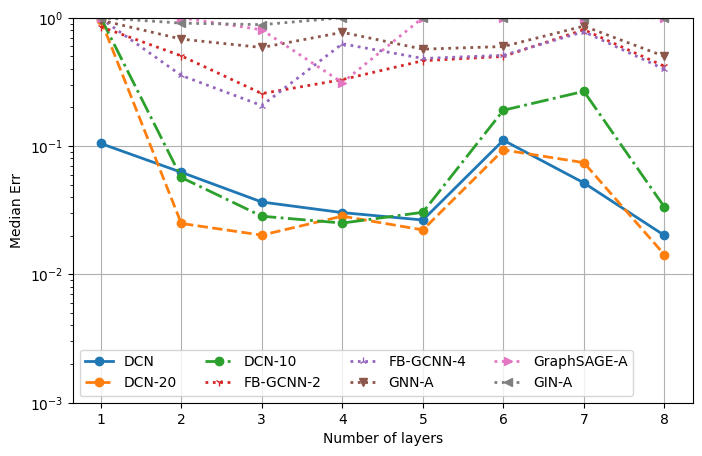

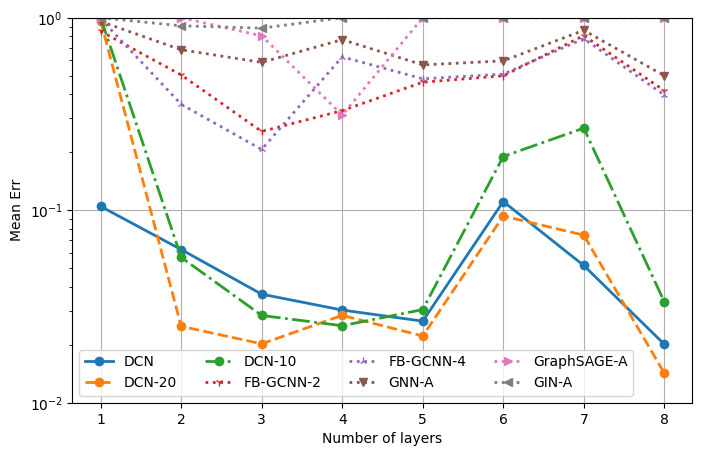

In [41]:
if SAVE:
    file_name = PATH + f'layers/n_layers_inf-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=N_layers)
    print('SAVED FILE:', file_name)

mean_err = err.mean(axis=0)
mean_time = times.mean(axis=0)
med_err = np.median(err, axis=0)
mean_std = np.mean(std, axis=0)
legend = [exp['leg'] for exp in Exps]
skip_idx = [8, 9, 10, 11]
# utils.plot_results(mean_err, N_layers, Exps, 'Number of layers', skip_idx=skip_idx, n_cols=2)
# utils.plot_results(mean_time, N_layers, Exps, 'Number of layer', ylabel='Mean time (seg)',
#                    skip_idx=skip_idx, n_cols=2, ylim_bottom=1, ylim_top=50)

# skip_idx = [0, 1, 2, 8]
# skip_idx = [0, 1, 2, 3, 5, 8]
skip_idx = []
utils.plot_results(med_err, N_layers, Exps, 'Number of layers', skip_idx=skip_idx, n_cols=4, ylabel='Median Err',
                   ylim_bottom=1e-3)
utils.plot_results(mean_err, N_layers, Exps, 'Number of layers', skip_idx=skip_idx, n_cols=4)



In [42]:
# file_name = PATH + 'layers/n_layers_inf-constant.npz'

### Varying the density of the graph

In [45]:
def influence_graph_density(d_dat_p, d_arc_p, d_mod_p, P_values, exps):
    err = np.zeros((d_dat_p['n_tries'], len(P_values), len(exps)))
    std = np.zeros((d_dat_p['n_tries'], len(P_values), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(P_values), len(exps)))
    
    t_begin = time.time()
    with tqdm(total=d_dat_p['n_tries']*len(exps)*len(P_values), disable=False) as pbar:
        for i in range(d_dat_p['n_tries']):
            print('Realization:', i)

            for j, p in enumerate(P_values):
                data_params_aux = dict(d_dat_p)
                data_params_aux['p'] = p            
                Adj, W, GSOs, Psi = utils.get_graph_data(data_params_aux, get_Psi=True)

                err[i,j], std[i,j], times[i,j] = run_exps(exps, d_arc_p, d_mod_p, data_params_aux, GSOs, W,
                                                          Adj, pbar, exp_desc=str(p), Psi=Psi)

                err[i,j][err[i,j] > 1] = 1

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')

    return err, std, times

In [46]:
P_values = [.1, .2, .3, .4, .5, .6, .7, .8]

Exps = [
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'mod_p': {}, 'leg': 'DCN', 'fmt': 'o-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 20}, 'mod_p': {}, 'leg': 'DCN-20', 'fmt': 'o--'},

    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'GSOs'}, 'leg': 'Linear', 'fmt': 's-'},

    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 4, 'transp': False}, 'leg': 'FB-GCNN-3', 'fmt': '2:'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'A'}, 'leg': 'GNN-A', 'fmt': 'v:'},
    {'arc_p': {'arch': GAT, 'GSO': 'A-dgl', 'args': {'num_heads': 2, 'hid_dim': 16, 'gat_params': {'attn_drop': 0}}},
     'leg': 'GAT-A', 'fmt': '^:'},
    {'arc_p': {'arch': GraphSAGE, 'GSO': 'A-dgl', 'args': {'hid_dim': 16, 'aggregator': 'mean'}}, 'leg': 'GraphSAGE-A',
     'fmt': '>:'},
    {'arc_p': {'arch': GIN, 'GSO': 'A-dgl', 'args': {'hid_dim': 16, 'aggregator': 'sum'}}, 'leg': 'GIN-A',
     'fmt': '<:'},
    ]

err, std, times = influence_graph_density(data_p, default_arch_args, default_mod_p, P_values, Exps)


  0%|          | 0/64 [00:00<?, ?it/s]

Realization: 0
	-0.1. DCN: err: 0.022 - time: 0.1
	-0.1. DCN-20: err: 0.036 - time: 0.1
	-0.1. Linear: err: 0.027 - time: 0.3
	-0.1. FB-GCNN-3: err: 0.469 - time: 0.1
	-0.1. GNN-A: err: 0.773 - time: 0.1
	-0.1. GAT-A: err: 0.761 - time: 0.9
	-0.1. GraphSAGE-A: err: 57.631 - time: 0.1
	-0.1. GIN-A: err: 0.842 - time: 0.1
	-0.2. DCN: err: 0.048 - time: 0.1
	-0.2. DCN-20: err: 0.095 - time: 0.1
	-0.2. Linear: err: 0.063 - time: 0.3
	-0.2. FB-GCNN-3: err: 0.693 - time: 0.1
	-0.2. GNN-A: err: 0.884 - time: 0.1
	-0.2. GAT-A: err: 0.965 - time: 0.8
	-0.2. GraphSAGE-A: err: 3.978 - time: 0.1
	-0.2. GIN-A: err: 2.032 - time: 0.1
	-0.3. DCN: err: 0.026 - time: 0.1
	-0.3. DCN-20: err: 0.089 - time: 0.1
	-0.3. Linear: err: 0.024 - time: 0.3
	-0.3. FB-GCNN-3: err: 0.245 - time: 0.1
	-0.3. GNN-A: err: 0.445 - time: 0.1
	-0.3. GAT-A: err: 0.735 - time: 0.8
	-0.3. GraphSAGE-A: err: 40.249 - time: 0.1
	-0.3. GIN-A: err: 1.111 - time: 0.1
	-0.4. DCN: err: 0.050 - time: 0.1
	-0.4. DCN-20: err: 0.019 - ti

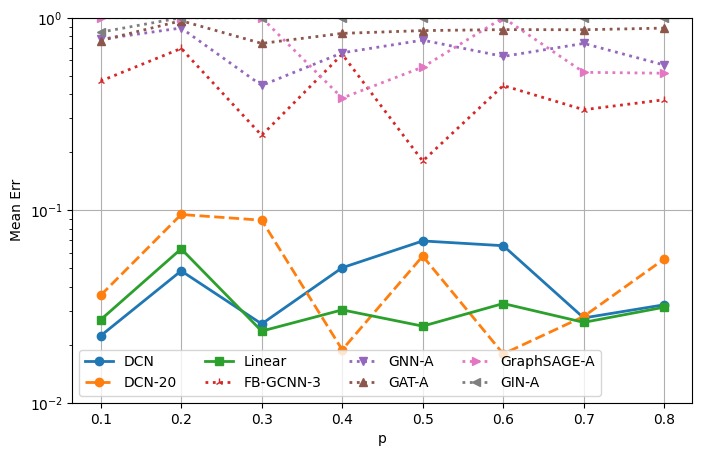

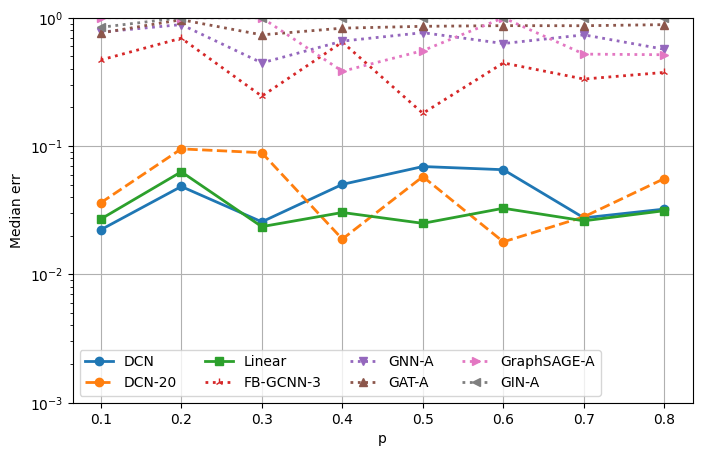

In [47]:
if SAVE:
    file_name = PATH + f'density_inf-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=P_values)
    print('SAVED FILE:', file_name)

mean_err = err.mean(axis=0)
mean_time = times.mean(axis=0)
med_err = np.median(err, axis=0)
legend = [exp['leg'] for exp in Exps]
utils.plot_results(mean_err, P_values, Exps, 'p', skip_idx=[], n_cols=4)

utils.plot_results(med_err, P_values, Exps, 'p', skip_idx=[], n_cols=4,
                   ylabel='Median err', ylim_bottom=1e-3)

In [48]:
# file_name = PATH + 'density_inf-constant.npz'
# err, std, times, Exps, P_values = utils.load_data(file_name)